In [1]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [3]:
import pickle

train_df = pickle.load(open('../Data/clpsych16_train_elmo_embeds.pkl', 'rb'))
test_df = pickle.load(open('../Data/clpsych16_test_elmo_embeds.pkl', 'rb'))

In [4]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [5]:
train_df.shape

(943, 3)

In [6]:
train_df.embeds[0].shape

(1024,)

In [8]:
xtrain, ytrain = train_df.embeds.values.tolist(), train_df.priority
xtest, ytest = test_df.embeds.values.tolist(), test_df.priority

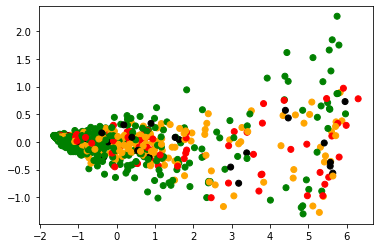

In [9]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

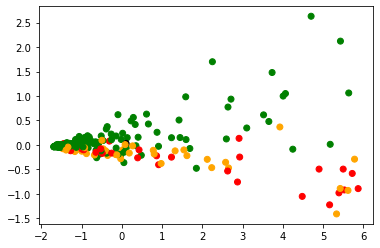

In [15]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [16]:
%%time

params = {'C': scipy.stats.expon(scale=10), 
          'gamma': scipy.stats.expon(scale=.1), 
          'kernel': ['rbf'], 
          'class_weight':['balanced'],
          'cache_size': [1024]}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

svc_searched_clf = clf.fit(xtrain, ytrain)

print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Best Params: {'C': 22.289095484186973, 'cache_size': 1024, 'class_weight': 'balanced', 'gamma': 0.05425323086169889, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.46120347159745984 

SVC(C=22.289095484186973, cache_size=1024, class_weight='balanced',
    gamma=0.05425323086169889) 

Wall time: 1min 56s


In [17]:
predicted_priority = svc_searched_clf.predict(xtest)    
print_results(ytest, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.54      0.57      0.56        47
    escalate       0.20      1.00      0.33         1
       green       0.92      0.88      0.90       165
         red       0.57      0.59      0.58        27

    accuracy                           0.79       240
   macro avg       0.56      0.76      0.59       240
weighted avg       0.81      0.79      0.80       240


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.49061751535978343

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.76      0.84      0.80        75
       green       0.92      0.88      0.90       165

    accuracy                           0.87       240
   macro avg       0.84      0.86      0.85       240
weighted avg       0.87      0.87      0.87       240


----URGENT - 'red + escalat